In [1]:
# Install the hugging face transformer and pytorch lighting
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

In [2]:
#importing the library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import torch
from pathlib import Path
from torch.utils.data import DataLoader,Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap
from transformers import AdamW,T5ForConditionalGeneration,T5TokenizerFast
import tqdm.auto as tqdm
from pylab import rcParams

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')

#set the seed value
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
#read the dataset
data=pd.read_excel("Bitext_Sample_Customer_Service_Training_Dataset.xlsx")
data.head()

,utterance,intent
0,I have problems with canceling an order,cancel_order
1,how can I find information about canceling ord...,cancel_order
2,I need help with canceling the last order,cancel_order
3,could you help me cancelling the last order I ...,cancel_order
4,problem with cancelling an order I made,cancel_order


In [4]:
data.shape

(8175, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8175 entries, 0 to 8174
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8175 non-null   object
 1   intent     8175 non-null   object
dtypes: object(2)
memory usage: 127.9+ KB


In [6]:
print("unique_utterance:",len(data.utterance.unique()))

unique_utterance: 8175


In [7]:
data.intent.value_counts()

get_invoice                 324
check_invoice               324
payment_issue               323
review                      315
track_refund                308
set_up_shipping_address     307
place_order                 306
track_order                 305
cancel_order                305
change_order                304
delivery_options            302
check_refund_policy         302
delivery_period             301
contact_customer_service    299
create_account              298
check_cancellation_fee      298
recover_password            298
complaint                   298
delete_account              298
check_payment_methods       297
change_shipping_address     297
contact_human_agent         297
registration_problems       296
newsletter_subscription     295
get_refund                  294
edit_account                294
switch_account              290
Name: intent, dtype: int64

<AxesSubplot:xlabel='count', ylabel='intent'>

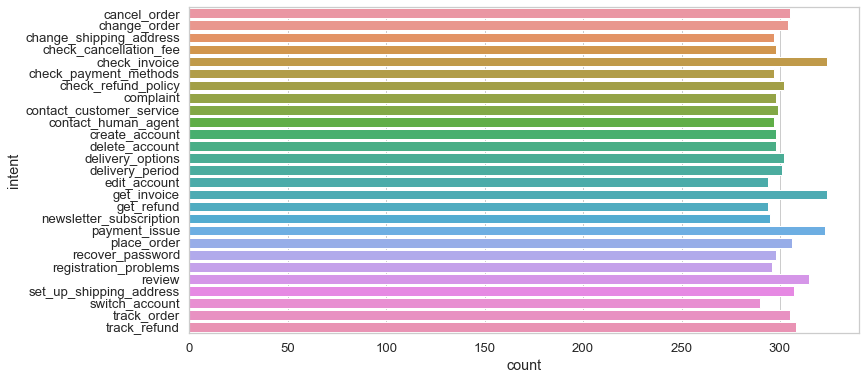

In [8]:
sns.countplot(y="intent",data=data)


In [9]:
#train test split the data
train_df,test_df=train_test_split(data,test_size=0.1)
print(train_df.shape,test_df.shape)

(7357, 2) (818, 2)


In [10]:
#initialize the tokenizer
model_name="t5-base"
tokenizer=T5TokenizerFast.from_pretrained(model_name)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

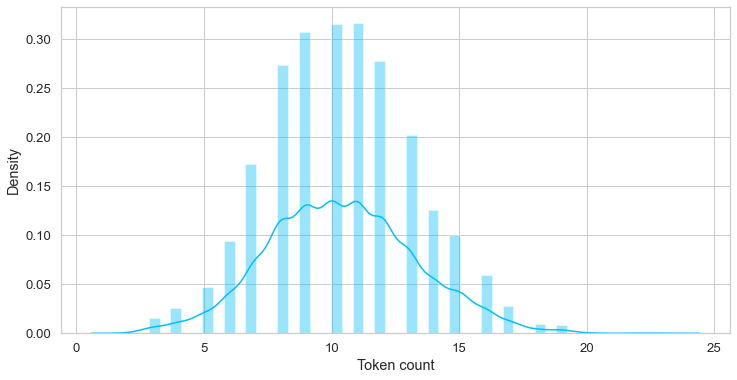

In [11]:
token_lens = []

for txt in data.utterance:
    tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlabel('Token count')    


Text(0.5, 0, 'Token count')

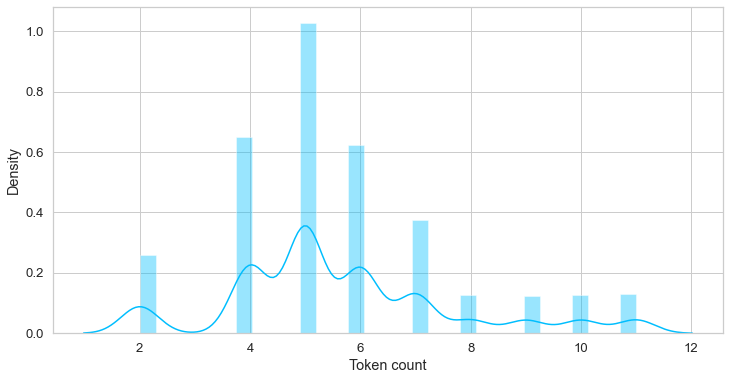

In [12]:
token_lens = []

for txt in data.intent:
    tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
#plt.xlim([0, 256]);
plt.xlabel('Token count') 

In [13]:

# create the model inputs (tokenized the data)
class UtteranceDataset(Dataset):
    def __init__(self,
                data:pd.DataFrame,
                tokenizer: T5TokenizerFast,
                text_max_token_len: int=18,
                intent_max_token_len: int=11):
        
        self.tokenizer=tokenizer
        self.data=data
        self.text_max_token_len=text_max_token_len
        self.intent_max_token_len=intent_max_token_len
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self,index: int):
        data_row=self.data.iloc[index]
        
        text=data_row["utterance"]
        intent=data_row["intent"]
        
        text_encoding=tokenizer(
        text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt")
        
        intent_encoding=tokenizer(
        intent,
        max_length=self.intent_max_token_len, #create the encodings vector of fixed length
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt")
        
        labels=intent_encoding["input_ids"] # input_ids=unique id of each token
        labels[labels==0]=-100 # avoid the computations of padding loss.  
        
        return dict(
        text=text,
        intent=intent,
        text_input_ids=text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=intent_encoding["attention_mask"].flatten())

In [14]:
# create the train + test tokenized dataset and train and test dataloader
class UtteranceDataModule(pl.LightningDataModule):
    def __init__(self,
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5TokenizerFast,
                batch_size: int=8,
                text_max_token_len: int=18,
                intent_max_token_len: int=11):
        super().__init__()
        
        self.train_df=train_df
        self.test_df=test_df
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.intent_max_token_len=intent_max_token_len
        
        #create dataset
    def setup(self,stage=None):
        self.train_dataset=UtteranceDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.intent_max_token_len)
        
        self.test_dataset=UtteranceDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.intent_max_token_len)
            
    #create the dataloader
    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True
        )
    def val_dataloader(self):
        return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False
        )


In [15]:
NB_EPOCHS=3
BATCH_SIZE=8

#initialize the data module .
data_module=UtteranceDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [16]:
#----------------Building the model-------------------------------------

class UtteranceModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model=T5ForConditionalGeneration.from_pretrained(model_name,return_dict=True)
        
    def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):
        output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask    
        )
        
        return output.loss,output.logits
    
     # To complete training loop(batch wise)
    def training_step(self,batch,batch_idx): 
        input_ids=batch["text_input_ids"]
        attention_mask=batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask=batch["labels_attention_mask"]
        
        # call the forward function
        loss,outputs=self(
        input_ids=input_ids,
        attention_mask=attention_mask,
            
        decoder_attention_mask=labels_attention_mask,
        labels=labels)
        
       
        self.log("train_loss",loss,prog_bar=True,logger=True)
        return loss
    
    # To complete validation loop(batch wise)
    def validation_step(self,batch,batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask=batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask=batch["labels_attention_mask"]
        
        # call the forward function
        loss,outputs=self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels)
        
       
        self.log("val_loss",loss,prog_bar=True,logger=True)
        return loss
    
    # To complete test loop(batch wise)
    def test_step(self,batch,batch_idx): 
        input_ids=batch["text_input_ids"]
        attention_mask=batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask=batch["labels_attention_mask"]
        
        # call the forward function
        loss,outputs=self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels)
        
       
        self.log("test_loss",loss,prog_bar=True,logger=True)
        return loss
    
    # define optimizers and LR schedulers
    def configure_optimizers(self):
        return AdamW(self.parameters(),lr=0.0001)
    

In [17]:
# Initialize the T5 model .   
model=UtteranceModel()

In [18]:
# build the model chaeckpoints 
check_point_callback=ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best_checkpoint",
                        save_top_k=1,
                        verbose=True,
                        monitor="val_loss",
                        mode="min")

#Trainer handles the training loop details
trainer=pl.Trainer(callbacks=[check_point_callback],
                  max_epochs=NB_EPOCHS)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
# start the training process
trainer.fit(model,data_module)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 920: 'val_loss' reached 0.00772 (best 0.00772), saving model to 'C:\\Users\\User\\Documents\\intents_classification_wit_T5_deepLearning_project\\checkpoints\\best_checkpoint.ckpt' as top 1


In [22]:
#load our trained model
trained_model=UtteranceModel.load_from_checkpoint(
                       trainer.checkpoint_callback.best_model_path)

trained_model.freeze()

In [23]:
#Create the intent classifications of the given text input.
def classified(text):
    text_encoding=tokenizer(
        text,
        max_length=18,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt")
    
    # Use of the trained model for generate the intents.
    generated_ids=trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=20,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True ) 
    
    preds = [
        tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    
    return "".join(preds)

In [27]:
#------------------- show the predictions---------------------------------

sample_row=test_df.iloc[0]
text=sample_row["utterance"]
model_output=classified(text)
print("text :",text)
print("Original_intent:",sample_row["intent"])  
print("Predicted_intent:",model_output) 

text : i have got to edit the goddamn info on my user profile
Original_intent: edit_account
Predicted_intent: edit_account


In [29]:
sample_row=test_df.iloc[55]
text=sample_row["utterance"]
model_output=classified(text)
print("text :",text)
print("Original_intent:",sample_row["intent"])  
print("Predicted_intent:",model_output) 

text : assistance to get the invoices from December
Original_intent: get_invoice
Predicted_intent: get_invoice


In [30]:
sample_row=test_df.iloc[110]
text=sample_row["utterance"]
model_output=classified(text)
print("text :",text)
print("Original_intent:",sample_row["intent"])  
print("Predicted_intent:",model_output) 

text : order cancellation
Original_intent: cancel_order
Predicted_intent: cancel_order
